# Bayesian Multinomial Logistic Regression
[Multinomial logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) is an extension of logistic regression. Logistic regression is used to model problems in which there are exactly two possible discrete outcomes. Multinomial logistic regression is used to model problems in which there are two or more possible discrete outcomes.

In our example, we'll be using the iris dataset. The goal of the iris multiclass problem is to predict the species of a flower given measurements (in centimeters) of sepal length and width and petal length and width. There are three possible species: Iris setosa, Iris versicolor, and Iris virginica.

To start, let's import all the libraries we'll need.

In [1]:
# Load Turing.
using Turing

# Load RDatasets.
using RDatasets

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

# Functionality for splitting and normalizing the data.
using MLDataUtils: shuffleobs, splitobs, rescale!

# We need a softmax function which is provided by NNlib.
using NNlib: softmax

# Set a seed for reproducibility.
using Random
Random.seed!(0)

# Hide the progress prompt while sampling.
Turing.setprogress!(false);

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/dtolpin/.julia/packages/Turing/PyTy2/src/Turing.jl:30
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /Users/dtolpin/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:15


## Data Cleaning & Set Up

Now we're going to import our dataset. Twenty rows of the dataset are shown below so you can get a good feel for what kind of data we have.

In [2]:
# Import the "iris" dataset.
data = RDatasets.dataset("datasets", "iris");

# Show twenty random rows.
data[rand(1:size(data, 1), 20), :]

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Cat…
1,6.8,3.0,5.5,2.1,virginica
2,5.1,3.8,1.5,0.3,setosa
3,6.1,2.8,4.0,1.3,versicolor
4,5.7,4.4,1.5,0.4,setosa
5,6.9,3.1,5.4,2.1,virginica
6,5.6,3.0,4.1,1.3,versicolor
7,7.2,3.2,6.0,1.8,virginica
8,6.0,3.0,4.8,1.8,virginica
9,6.6,2.9,4.6,1.3,versicolor


In this data set, the outcome `Species` is currently coded as a string. We convert it to a numerical value by using indices `1`, `2`, and `3` to indicate species `setosa`, `versicolor`, and `virginica`, respectively.

In [3]:
# Recode the `Species` column.
species = ["setosa", "versicolor", "virginica"]
data[!, :Species_index] = indexin(data[!, :Species], species)

# Show twenty random rows of the new species columns
data[rand(1:size(data, 1), 20), [:Species, :Species_index]]

,Species,Species_index
,Cat…,Union…
1,setosa,1
2,versicolor,2
3,setosa,1
4,versicolor,2
5,virginica,3
6,virginica,3
7,setosa,1
8,setosa,1
9,versicolor,2


After we've done that tidying, it's time to split our dataset into training and testing sets, and separate the features and target from the data. Additionally, we must rescale our feature variables so that they are centered around zero by subtracting each column by the mean and dividing it by the standard deviation. Without this step, Turing's sampler will have a hard time finding a place to start searching for parameter estimates.

In [4]:
# Split our dataset 50%/50% into training/test sets.
trainset, testset = splitobs(shuffleobs(data), 0.5)

# Define features and target.
features = [:SepalLength, :SepalWidth, :PetalLength, :PetalWidth]
target = :Species_index

# Turing requires data in matrix and vector form.
train_features = Matrix(trainset[!, features])
test_features = Matrix(testset[!, features])
train_target = trainset[!, target]
test_target = testset[!, target]

# Standardize the features.
μ, σ = rescale!(train_features; obsdim = 1)
rescale!(test_features, μ, σ; obsdim = 1);

## Model Declaration

Finally, we can define our model `logistic_regression`. It is a function that takes three arguments where

- `x` is our set of independent variables;
- `y` is the element we want to predict;
- `σ` is the standard deviation we want to assume for our priors.

We select the `setosa` species as the baseline class (the choice does not matter). Then we create the intercepts and vectors of coefficients for the other classes against that baseline. More concretely, we create scalar intercepts `intercept_versicolor` and `intersept_virginica` and coefficient vectors `coefficients_versicolor` and `coefficients_virginica` with four coefficients each for the features `SepalLength`, `SepalWidth`, `PetalLength` and `PetalWidth`. We assume a normal distribution with mean zero and standard deviation `σ` as prior for each scalar parameter. We want to find the posterior distribution of these, in total ten, parameters to be able to predict the species for any given set of features.

In [5]:
# Bayesian multinomial logistic regression
@model function logistic_regression(x, y, σ)
    n = size(x, 1)
    length(y) == n || throw(DimensionMismatch("number of observations in `x` and `y` is not equal"))

    # Priors of intercepts and coefficients.
    intercept_versicolor ~ Normal(0, σ)
    intercept_virginica ~ Normal(0, σ)
    coefficients_versicolor ~ MvNormal(4, σ)
    coefficients_virginica ~ MvNormal(4, σ)

    # Compute the likelihood of the observations.
    values_versicolor = intercept_versicolor .+ x * coefficients_versicolor
    values_virginica = intercept_virginica .+ x * coefficients_virginica
    for i in 1:n
        # the 0 corresponds to the base category `setosa`
        v = softmax([0, values_versicolor[i], values_virginica[i]])
        y[i] ~ Categorical(v)
    end
end;

## Sampling

Now we can run our sampler. This time we'll use [`HMC`](http://turing.ml/docs/library/#Turing.HMC) to sample from our posterior.

In [6]:
chain = sample(logistic_regression(train_features, train_target, 1), HMC(0.05, 10), MCMCThreads(), 1500, 3)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/dtolpin/.julia/packages/AbstractMCMC/oou1a/src/sample.jl:253


Chains MCMC chain (1500×19×3 Array{Float64,3}):

Iterations        = 1:1500
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1500
parameters        = coefficients_versicolor[1], coefficients_versicolor[2], coefficients_versicolor[3], coefficients_versicolor[4], coefficients_virginica[1], coefficients_virginica[2], coefficients_virginica[3], coefficients_virginica[4], intercept_versicolor, intercept_virginica
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
                  parameters      mean       std   naive_se      mcse        e ⋯
                      Symbol   Float64   Float64    Float64   Float64    Float ⋯

  coefficients_versicolor[1]    1.0419    0.6297     0.0094    0.0294   471.92 ⋯
  coefficients_versicolor[2]   -1.4849    0.5686     0.0085    0.0253   618.65 ⋯
  coefficients_versicolor[3]    1.0697    0.7395     0.0110    0.0408   380.3

Since we ran multiple chains, we may as well do a spot check to make sure each chain converges around similar points.

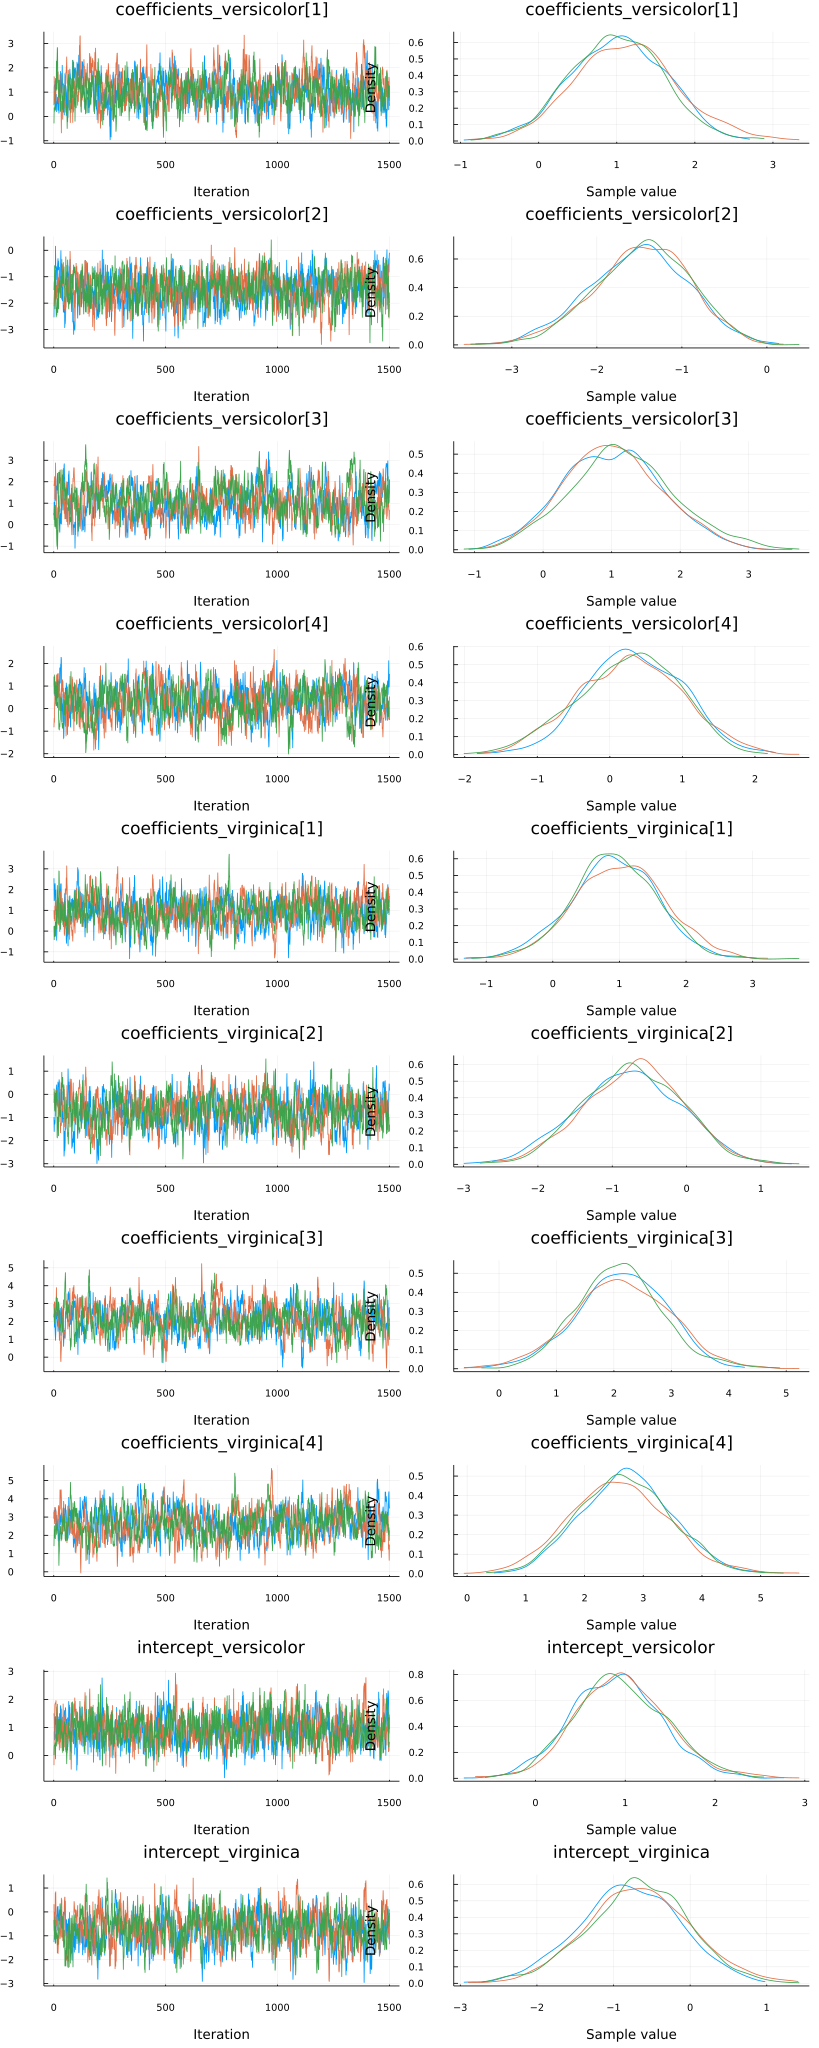

In [7]:
plot(chain)

Looks good!

We can also use the `corner` function from MCMCChains to show the distributions of the various parameters of our multinomial logistic regression. The corner function requires MCMCChains and StatsPlots.

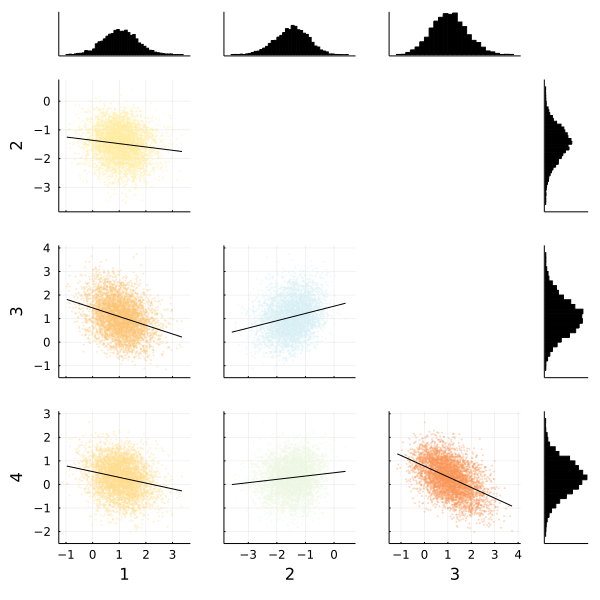

In [8]:
corner(
    chain, [Symbol("coefficients_versicolor[$i]") for i in 1:4];
    label=[string(i) for i in 1:4], fmt=:png
)

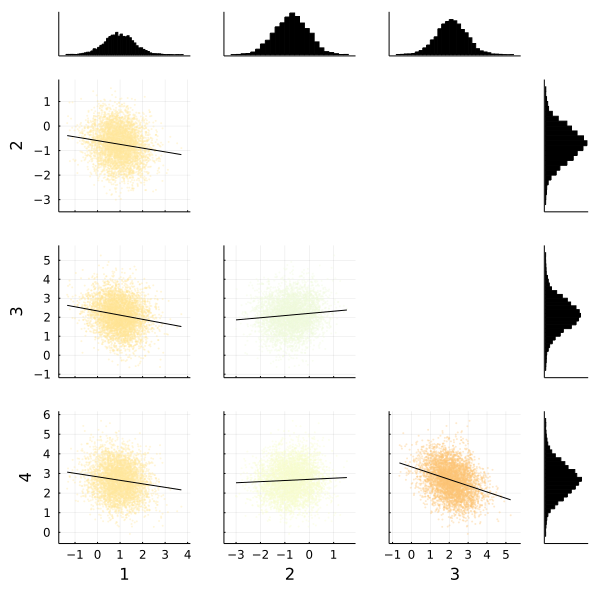

In [9]:
corner(
    chain, [Symbol("coefficients_virginica[$i]") for i in 1:4];
    label=[string(i) for i in 1:4], fmt=:png
)

Fortunately the corner plots appear to demonstrate unimodal distributions for each of our parameters, so it should be straightforward to take the means of each parameter's sampled values to estimate our model to make predictions.

## Making Predictions

How do we test how well the model actually predicts whether someone is likely to default? We need to build a `prediction` function that takes the test dataset and runs it through the average parameter calculated during sampling.

The `prediction` function below takes a `Matrix` and a `Chains` object. It computes the mean of the sampled parameters and calculates the species with the highest probability for each observation. Note that we do not have to evaluate the `softmax` function since it does not affect the order of its inputs.

In [10]:
function prediction(x::Matrix, chain)
    # Pull the means from each parameter's sampled values in the chain.
    intercept_versicolor = mean(chain, :intercept_versicolor)
    intercept_virginica = mean(chain, :intercept_virginica)
    coefficients_versicolor = [mean(chain, "coefficients_versicolor[$i]") for i in 1:4]
    coefficients_virginica = [mean(chain, "coefficients_virginica[$i]") for i in 1:4]

    # Compute the index of the species with the highest probability for each observation.
    values_versicolor = intercept_versicolor .+ x * coefficients_versicolor
    values_virginica = intercept_virginica .+ x * coefficients_virginica
    species_indices = [argmax((0, x, y)) for (x, y) in zip(values_versicolor, values_virginica)]
    
    return species_indices
end;

Let's see how we did! We run the test matrix through the prediction function, and compute the accuracy for our prediction.

In [11]:
# Make the predictions.
predictions = prediction(test_features, chain)

# Calculate accuracy for our test set.
mean(predictions .== testset[!, :Species_index])

0.92

Perhaps more important is to see the accuracy per class.

In [12]:
for s in 1:3
    rows = testset[!, :Species_index] .== s
    println("Number of `", species[s], "`: ", count(rows))
    println("Percentage of `", species[s], "` predicted correctly: ",
        mean(predictions[rows] .== testset[rows, :Species_index]))
end

Number of `setosa`: 24
Percentage of `setosa` predicted correctly: 0.9583333333333334
Number of `versicolor`: 25
Percentage of `versicolor` predicted correctly: 0.88
Number of `virginica`: 26
Percentage of `virginica` predicted correctly: 0.9230769230769231


This tutorial has demonstrated how to use Turing to perform Bayesian multinomial logistic regression. 